In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
pd.set_option('display.max_columns', None)

from matplotlib import rc
rc('text',usetex=True)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
rc('text.latex', preamble='\\usepackage{color} \\usepackage{amsmath} \\usepackage{amssymb}')

In [11]:
method_remap = {
    'max_IoU': '$\\mathit{max{-}IoU}$',
    'au_IoU': '$\\mathit{AU{-}IoU}$',
    'time_exp': 'time',
    'aucI_clipr': '$\\mathit{AUC}^+$',
    'aucD_clipr': '$\\mathit{AUC}^-$',
}
method_ascending = { # false = lower is better
    'max_IoU': False,
    'au_IoU': False,
    'aucI_pred': False,
    'aucD_pred': True,
    'time_exp': True,
    'aucI_clipr': False,
    'aucD_clipr': True,}
method_colors = {
    'BPT-100':         '#f2a7c0',
    'BPT-500':         '#db587f',
    'BPT-1000':        '#9d2f4d',
    'AA-100':   '#4ed1f9',
    'AA-500':   '#00b1f2',
    'AA-1000':  '#008fe8',
    'LIME-100':         '#c7e883',
    'LIME-500':        '#8fc543',
    'LIME-1000':        '#66912d',
    'LRP':        '#008080',
    'GradCAM':         'xkcd:camel',
    'aIDG':            '#fcd459',
    'aGradExpl':       '#dd7c2b',
    'GradShap':       '#800000',
}
experiment_colors = {
    "E1": "blue",
    "E2": "green",
    "E3": "orange",
    "E4": "purple",
    "E5": "aqua",
    "E6": "pink",
    "E7": "coral",
}
experiment_markers = {
    "E1": "o",
    "E2": "v",
    "E3": "^",
    "E4": "s",
    "E5": "*",
    "E6": "D",
    "E7": "X",
}
name_remap = {
    'BPT-100': 'BPT-100',
    'BPT-500': 'BPT-500',
    'BPT-1000': 'BPT-1000',
    'aIDG': '$|$IDG$|$',
    'aGradExpl': '$|$GradExpl$|$',
}
result_remap_table = {
    'Partition-100': 'AA-100',
    'Partition-500': 'AA-500',
    'Partition-1000': 'AA-1000',
}

In [12]:
data_sources = [
    ('E1', 'results_logits_with_auc_clipped/csv_exp_E1_ImageNet_resnet_real_gray_logits.csv'),
    ('E2', 'results_logits_with_auc_clipped/csv_exp_E2_ImageNet_resnet_ideal_gray_logits.csv'),
    ('E3', 'results_logits_with_auc_clipped/csv_exp_E3_ImageNet_swin_trans_vit_real_gray_logits.csv'),
    ('E4', 'results_logits_with_auc_clipped/csv_exp_E4_yolo11s_gray_9.csv'),
    ('E5', 'results_logits_with_auc_clipped/csv_exp_E5_IoU_face_1000_14_gray_brownhairs.csv'),
    # ('E6', 'results_logits_with_auc_clipped/csv_exp_E6_testresults_hazelnut_30000_9_BPT_new_eval.csv'),
    ('E6', 'results_logits_with_auc_clipped/csv_exp_E6_testresults_hazelnut_9_BPT_new_eval.csv'),
    ('E7', 'results_logits_with_auc_clipped/csv_exp_E7_ImageNet_vit_real_gray_logits.csv')

]

data = []
for Ex, fname in data_sources:
    df = pd.read_csv(fname)
    df['Experiment'] = Ex
    data.append(df)

data = pd.concat(data)
data = data[data.method.isin(method_colors.keys())]
data.method = data.method.replace(name_remap)
print(data.method.unique())
data.head(3)

['BPT-100' 'BPT-500' 'BPT-1000' 'LIME-100' 'LIME-500' 'LIME-1000' 'LRP'
 'GradCAM' '$|$IDG$|$' '$|$GradExpl$|$' 'AA-100' 'AA-500' 'AA-1000']


,Unnamed: 0,image,bg_type,pred_cls,pred_lbl,f_S,f_0,delta_f,f_G,f_B,f_T,f_N,method,aucI_pred,aucD_pred,aucI_r,aucD_r,aucI_adj,aucD_adj,aucI_adj_r,aucD_adj_r,aucI_clip,aucI_clipr,aucD_clip,aucD_clipr,threshold,best_point,max_IoU,au_IoU,time_load,time_exp,time_aucI,time_aucD,time_auc_IoU,time_total,Experiment,image_size,inference_time,object_count,auc_IoU,background_type,intrested_class,intrested_class_lbl,real_class,true_intrested_class,time_IoU,time_plotting,a_type_id,a_type,img_no,mask_type,target_segs,num_samples,anomaly_score,anomaly_score_val,AM_roc_score,auroc,max_heatmap
0,0,ILSVRC2012_val_00004677,gray,1.0,goldfish,7.596925,0.682357,6.914568,3.264282,5.60901,6.914568,16,BPT-100,5.707129,0.952612,0.825378,0.137769,5.640350,0.985684,0.815720,0.142552,5.670734,0.820114,0.953440,0.137889,0.000346,0.151287,0.340554,0.172041,0.092016,0.387638,0.064448,0.095695,0.065855,0.705651,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ILSVRC2012_val_00004677,gray,1.0,goldfish,7.596925,0.682357,6.914568,3.264282,5.60901,6.914568,53,BPT-500,5.823362,1.381779,0.842187,0.199836,5.739473,1.386621,0.830055,0.200536,5.781418,0.836121,1.065356,0.154074,0.000578,0.061165,0.313926,0.161628,0.092016,1.293927,0.120714,0.130432,0.060365,1.697453,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ILSVRC2012_val_00004677,gray,1.0,goldfish,7.596925,0.682357,6.914568,3.264282,5.60901,6.914568,83,BPT-1000,5.993603,1.339248,0.866808,0.193685,5.789267,1.343999,0.837256,0.194372,5.891435,0.852032,0.933931,0.135067,0.000427,0.093571,0.352495,0.165435,0.092016,2.426728,0.170663,0.169707,0.073327,2.932441,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ANNOVA TEST

In [13]:
############################################################
auc_methods      = [
                    'aucI_clipr' ,'aucD_clipr', \
                    'max_IoU','au_IoU',\
                    'time_exp']

############################################################
from scipy.stats import f_oneway

def get_annova_results(Ex,df,auc_methods, verbose=True):

    if Ex=='E4':
        if verbose:
            print('RENAMING', ' ----- > auc_IoU', 'au_IoU')
        df = df.rename(columns={'auc_IoU': 'au_IoU'})
    data_csv = []
    methods = sorted(df.method.unique())
    for score in auc_methods:
        if score=='time_exp':
            continue
        pops = []
        for m1 in methods:
            # print(m1, )
            pops.append(df[score][df.method==m1].values)
        
        anova = f_oneway(*pops)
        if verbose:
            print(f"| {score:<20} | {anova.pvalue:<20} |")
        data_ = {'Experiment': Ex,
            'score':score,
                'pvalue':anova.pvalue
                }
        data_csv.append(data_)

    return data_csv, pd.DataFrame(data_csv)
# get_annova_results(Ex,df,auc_methods, verbose=True)
############################################################
def inspect_df(df, Ex):
    computed_methods = df.method.unique()
    num_methods = len(computed_methods)
    if Ex!='E6':
        num_images  = len(np.unique(df.image))
    else:
        num_images = 70
    return computed_methods,num_methods,num_images

In [14]:
print(f'{"Experiment":<20} | {"XAI Methods":<20} | {"Num Images":<20}')
result_annova_csv = []
for Ex, fname in data_sources:
    df = pd.read_csv(fname)

    computed_methods,num_methods,num_images = inspect_df(df,Ex)
    print(f'{Ex:<20} | {num_methods:<20} | {num_images:<20}')
    result_annova,df_temp = get_annova_results(Ex,df,auc_methods, verbose=False)
    # for r in result_annova:
        # r["num_methods"] = num_methods
        # r["num_images"] = num_images
    print('-'*100)
    display(df_temp)
    result_annova_csv.extend(result_annova)

    # result_annova_csv.append(result_annova)
    df_annova = pd.DataFrame(result_annova_csv)

    # print('-'*50)

df_annova

Experiment           | XAI Methods          | Num Images          
E1                   | 14                   | 574                 
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E1,aucI_clipr,0.000000e+00
1,E1,aucD_clipr,4.100430e-197
2,E1,max_IoU,0.000000e+00
3,E1,au_IoU,2.488676e-135


E2                   | 12                   | 574                 
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E2,aucI_clipr,0.0
1,E2,aucD_clipr,0.0
2,E2,max_IoU,0.0
3,E2,au_IoU,0.0


E3                   | 14                   | 621                 
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E3,aucI_clipr,0.000000e+00
1,E3,aucD_clipr,4.558186e-248
2,E3,max_IoU,0.000000e+00
3,E3,au_IoU,0.000000e+00


E4                   | 9                    | 274                 
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E4,aucI_clipr,1.089662e-111
1,E4,aucD_clipr,1.538728e-15
2,E4,max_IoU,1.937659e-96
3,E4,au_IoU,1.287060e-18


E5                   | 14                   | 436                 
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E5,aucI_clipr,0.000000e+00
1,E5,aucD_clipr,0.000000e+00
2,E5,max_IoU,1.361663e-31
3,E5,au_IoU,1.637306e-13


E6                   | 9                    | 70                  
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E6,aucI_clipr,2.122062e-145
1,E6,aucD_clipr,4.030933e-175
2,E6,max_IoU,8.527650e-260
3,E6,au_IoU,9.055534e-03


E7                   | 13                   | 593                 
----------------------------------------------------------------------------------------------------


,Experiment,score,pvalue
0,E7,aucI_clipr,0.000000e+00
1,E7,aucD_clipr,1.273633e-209
2,E7,max_IoU,0.000000e+00
3,E7,au_IoU,6.055276e-162


,Experiment,score,pvalue
0,E1,aucI_clipr,0.000000e+00
1,E1,aucD_clipr,4.100430e-197
2,E1,max_IoU,0.000000e+00
3,E1,au_IoU,2.488676e-135
4,E2,aucI_clipr,0.000000e+00
5,E2,aucD_clipr,0.000000e+00
6,E2,max_IoU,0.000000e+00
7,E2,au_IoU,0.000000e+00
8,E3,aucI_clipr,0.000000e+00
9,E3,aucD_clipr,4.558186e-248


In [15]:
score_target = 'max_IoU'
df = data.groupby(['Experiment', 'method'])[score_target].mean().reset_index()
display(df.head(3))
f = (df.Experiment=='E6') & (df.method.isin(['aucI_mse', 'aucD_mse']))
df[f][score_target] = df[f][score_target] / 100
# df = df[].score_target *= 100
# df = df[(df.Experiment=='E6') & (df.method=='aucD_mse')].score_target *= 100
# df.to_csv('max_IoU.csv')

,Experiment,method,max_IoU
0,E1,$|$GradExpl$|$,0.348641
1,E1,$|$IDG$|$,0.403870
2,E1,BPT-100,0.627973


In [16]:
# df.method

In [17]:
# plt.figure(figsize=(10, 6))
# for method in df['method'].unique():
#     subset = df[df['method'] == method]
#     plt.scatter(subset['Experiment'], subset['max_IoU'], label=method)

# plt.xlabel('Experiment')
# plt.ylabel('Max IoU')
# plt.title('Scatterplot of Experiments Datapoints')
# plt.legend(title='Method')
# plt.xticks(rotation=90)
# plt.show()

In [18]:
# # Calculate the median point for each method
# median_points = df.groupby('method')['max_IoU'].mean().reset_index()
# median_points = median_points.sort_values(by='max_IoU', ascending=False)
# display(median_points)
# # median_points.columns = ['method', 'median_max_IoU']

# # Merge the median points with the original dataframe
# # df2 = df.merge(median_points, on='method')



# # Sort the dataframe by the median points in descending order
# df2 = df.sort_values(by='max_IoU', ascending=False)

# # Sort the median points dataframe by the median_max_IoU column
# # median_points = median_points.sort_values(by='median_max_IoU', ascending=False)

# plt.figure(figsize=(10, 6))
# for experiment in df2['Experiment'].unique():
#     subset = df2[df2['Experiment'] == experiment]
#     plt.scatter(subset['method'], subset['max_IoU'], label=experiment)

# # Plot the median points
# # plt.plot(median_points['method'], median_points['median_max_IoU'], 'x-', color='red', label='Median Points')

# plt.xlabel('Method')
# plt.ylabel('Max IoU')
# plt.title('Scatterplot of Experiments Datapoints with Median Points')
# plt.legend(title='Experiment')
# plt.xticks(rotation=90)
# plt.show()

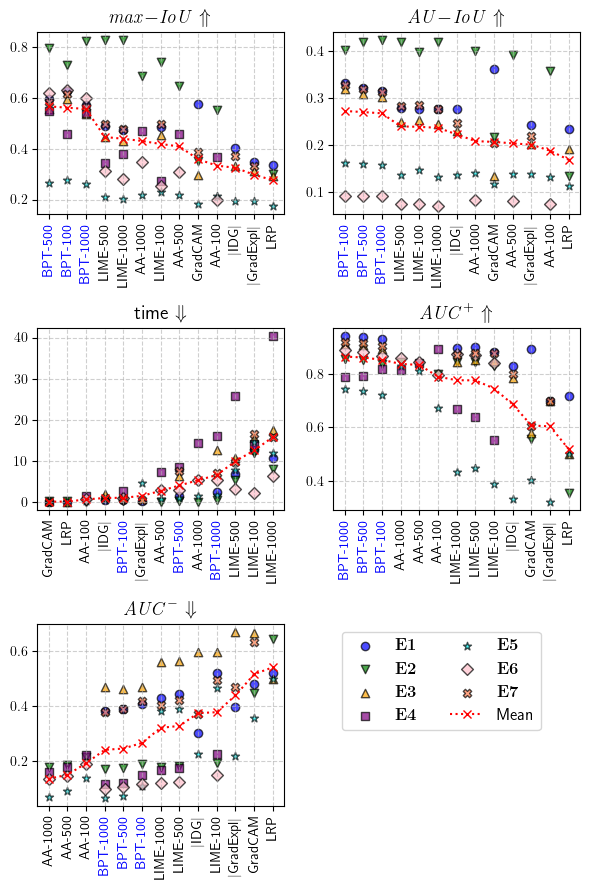

In [19]:
# Create figure and axis
NC = 7
fig,axes = plt.subplots(3,2, figsize=(6, 9))  #(3, 2)

for ii, score_target in enumerate(method_remap.keys()):
    ax = axes.flatten()[ii]
    df = data.groupby(['Experiment', 'method'])[score_target].mean().reset_index()
    if score_target in ['aucI_pred', 'aucD_pred']:
        f = (df.Experiment=='E6')
        # print(f.sum())
        df.loc[f, score_target] = df[f][score_target] / 200.0
        f = (df.Experiment=='E5')
        df.loc[f, score_target] = df[f][score_target] / 6.0
    # elif score_target in ['aucI_mse', 'aucD_mse']:
    #     f = (df[score_target]>100)
    #     df = df[~f]


    method_means = df.groupby("method")[score_target].mean().sort_values(ascending=method_ascending[score_target])
    sorted_methods = method_means.index.tolist()
    method_pos = {m:i for i,m in enumerate(sorted_methods)}
    # print(sorted_methods)

    # Dictionary to track legend entries to avoid duplicates
    legend_labels = {}

    # Plot individual experiment points (swarm effect) with fixed colors
    for _, row in df.iterrows():
        color = experiment_colors[row["Experiment"]]
        marker = experiment_markers[row["Experiment"]]
        label = row["Experiment"]
        
        # Ensure each experiment appears only once in the legend
        if label not in legend_labels:
            legend_labels[label] = True
        else:
            label = None
            # plt.scatter(row["method"], row[score_target], color=color, alpha=0.7, edgecolors="k")
        ax.scatter(method_pos[row["method"]], row[score_target], color=color, alpha=0.7, label=label, edgecolors="k", marker=marker)

    # Plot mean values as a line
    ax.plot(range(len(sorted_methods)), method_means.values, marker='x', linestyle=':', color='red', label="Mean IoU")

    if score_target in ['aucI_mse', 'aucD_mse']:
        ax.set_yscale('log')

    # Adjustments and labeling
    ax.set_xticks(range(len(sorted_methods)), sorted_methods, rotation=90)
    # plt.xlabel("Method")
    title = method_remap[score_target]
    title += '  '+('$\\Downarrow$' if method_ascending[score_target] else '$\\Uparrow$')
    ax.set_title(title, fontsize=14)
    # plt.title("Swarm Plot of max_IoU by Method (Sorted by Mean) with Experiments")
    # plt.legend(title="Experiment", bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", alpha=0.6)

    # ax = plt.gca()  # Get current axis
    # xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    for label, method in zip(xticklabels, sorted_methods):
        if 'BPT' in method:
            label.set_color('blue')
        # label.set_color(method_colors.get(method, "black"))

ax = axes.flatten()[-1]
# Plot dummy points for each experiment to be used in the legend
legend_handles = []
for exp, color in experiment_colors.items():
    handle = ax.scatter([], [], color=color, label='\\bf '+exp, alpha=0.7, edgecolors="k", marker=experiment_markers[exp])
    legend_handles.append(handle)

# Add mean line to the legend
mean_handle = ax.plot([], [], marker='x', linestyle=':', color='red', label="Mean")[0]
legend_handles.append(mean_handle)

# Create the legend
# ax.legend(handles=legend_handles, loc="upper left", fontsize=12, ncols=1)
ax.legend(handles=legend_handles, loc="upper left", fontsize=12, ncols=2)
ax.axis("off")  # Hide axes

# Show the plot
# axes.flatten()[-1].set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0.0)
plt.tight_layout()
plt.savefig('all_scores_wo_mse.pdf', transparent=True, bbox_inches='tight', pad_inches=0.02)
plt.show()
    # break

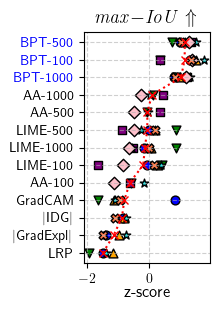

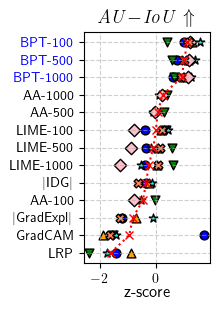

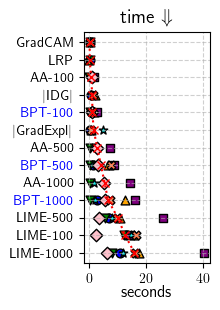

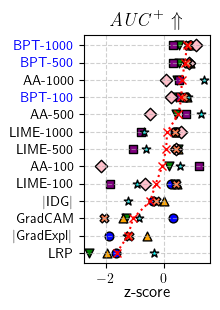

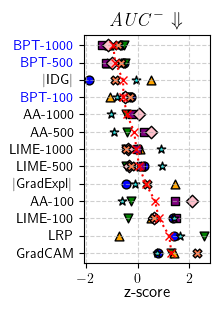

In [20]:
for score_target in method_remap.keys():
    df = data.groupby(['Experiment', 'method'])[score_target].mean().reset_index()

    if score_target == 'time_exp':
        value_target = score_target
        label_target = 'seconds'
    else:
        # Calculate z-scores within each Experiment group
        df['z_score'] = df.groupby('Experiment')[score_target].transform(
            lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
        )
        value_target = 'z_score' 
        label_target = 'z-score'

    # value_target, label_target = score_target, score_target

    method_means = df.groupby("method")[value_target].mean().sort_values(ascending=not method_ascending[score_target])
    sorted_methods = method_means.index.tolist()
    method_pos = {m:i for i,m in enumerate(sorted_methods)}
    method_support = {m:0 for m in sorted_methods}

    plt.figure(figsize=(2.3, 3.2))
    legend_labels = {}

    for _, row in df.iterrows():
        color = experiment_colors[row["Experiment"]]
        marker = experiment_markers[row["Experiment"]]
        label = row["Experiment"]
        if label not in legend_labels:
            legend_labels[label] = True
        else:
            label = None
        plt.scatter(row[value_target], method_pos[row["method"]], 
                    color=color, alpha=1.0, 
                    label=label, edgecolors="k", marker=marker, s=40)
        method_support[row["method"]] += 1

    plt.plot(method_means.values, range(len(sorted_methods)), marker='x', linestyle=':', color='red', label="Mean")

    plt.yticks(range(len(sorted_methods)), sorted_methods)
    title = method_remap[score_target] 
    plt.xlabel(label_target, fontsize=12, labelpad=0)
        # title += " ($z$-scores)"
    title += '  '+('$\\Downarrow$' if method_ascending[score_target] else '$\\Uparrow$')
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)

    ax = plt.gca()
    ticklabels = ax.get_yticklabels()
    for label, method in zip(ticklabels, sorted_methods):
        if 'BPT' in method:
            label.set_color('blue')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.tight_layout()
    plt.savefig(f'paper_figures/h_scores_{score_target}_summary.svg', bbox_inches='tight', pad_inches=0.05, dpi=300, transparent=True)
    plt.show()


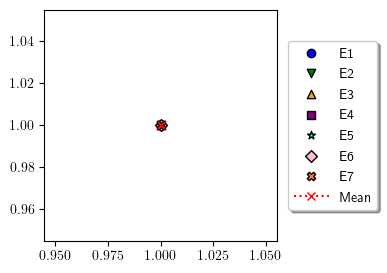

In [22]:
plt.figure(figsize=(3,3))
handles = []
for i, ex in enumerate(experiment_colors.keys()):
    color = experiment_colors[ex]
    marker = experiment_markers[ex]

    plt.scatter(1,1, color=color, marker=marker, label=ex, edgecolor='black')

plt.plot(1,1, marker='x', linestyle=':', color='red', label="Mean")

plt.legend(ncols=1, loc='center left', bbox_to_anchor=(1.02, 0.5), 
        fancybox=True, shadow=True, handleheight=1, handlelength=2.5)
plt.savefig(f'paper_figures/legend_summary.svg', transparent=True, dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()